# Detrended Fluctuation Analysis

Detrended Fluctuation Analysis is a method for measuring the self-similarity of a signal, and can be applied to measure properties of 1/f-distributed signals.

DFA measures an output value, $\alpha$ which can be interpreted as:
- $\alpha$ < 0.5   anti-correlated signal
- $\alpha$ ~= 0.5: uncorrelated / white noise
- $\alpha$ > 0.5: correlated
    - For example: pink noise ($1/f^1$) ~= 1 & brown noise ($1/f^2$) ~= 1.5

The DFA measure $\alpha$, _should_ relate to the power spectrum exponent $f^\chi$ as:
- $\chi$ = 2$\alpha$ - 1 or
- $\alpha$ = ($\chi$ + 1) / 2

In this notebook, we will explore:
- applying DFA to neural time signals
- how DFA measures relate to different properties of neural time series
- compare DFA measures to other measures of 1/f. 



### Notes
- It looks like the expected relationship between DFA & 1/f appears to be true in the range of $\chi$ from -3 to 0. 
    - It seems like it breaks down with exponent of less than -3
    - It also doesn't seem to hold for exponents > 0
- The presence of an oscillations decreases measures DFA
    - Increasing the frequency of the oscillation further decreases measured DFA
    - Increasing the relative power of the oscillation further decreases measured DFA
- It would appear that given a combined signal, the measured DFA is upper-bound at the expected DFA given the exponent

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from neurodsp.sim import *

from neurodsp.spectral import compute_spectrum
from fooof.plts import plot_spectra

In [2]:
import seaborn as sns
sns.set_context('talk')

In [3]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.run import run_sims

## Settings

In [5]:
# Simulation settings
n_seconds = 30
fs = 1000
default_exp = -2
default_freq = 10

# Collect together simulation parameters
sim_params_pow = {'n_seconds' : n_seconds, 'fs' : fs}

sim_params_comb = {'n_seconds' : n_seconds, 'fs' : fs,
                   'components' : {'sim_powerlaw' : {'exponent' : default_exp},
                                   'sim_oscillation' : {'freq' : default_freq}}}

# DFA settings
dfa_params = {
    'fs' : fs,
    'n_scales' : 10,
    'min_scale' : 0.1,
    'max_scale' : 1.0,
    'deg' : 1,
    'method' : 'dfa'
}

# Set the number of instances to run
n_instances = 10

# Set the exponent range to simulate across
exps = np.arange(-3, 0.25, 0.25)

freqs = np.arange(1, 50, 2)

pows = np.arange(0, 1, 0.1)

In [6]:
# Set the random seed
np.random.seed(111)

## Helper Functions

In [7]:
def expected_alpha(exp):
    return (-exp + 1) / 2

In [8]:
def dfa_wrapper(sig, **kwargs):
    return dfa(sig, **kwargs)[2]

## DFA on Example Signals

### Powerlaw Signal

In [9]:
# Set an example exponent to simulate
exp = -2

In [10]:
# Simulate a powerlaw signal
sig_pl = sim_powerlaw(n_seconds, fs, exp)

In [11]:
# Calculat DFA on the simulated signal
_, _, dfa_res = dfa(sig_pl, **dfa_params)

In [12]:
# Check the calculate DFA exponent, and the expected value
print('DFA exponent: \t\t {:1.4f}'.format(dfa_res))
print('Expected Alpha:\t\t {:1.4f}'.format(expected_alpha(exp)))

DFA exponent: 		 1.5284
Expected Alpha:		 1.5000


### Knee Signal

In [13]:
# Expected exp
exp_kn = -2

In [14]:
sig_kn = sim_synaptic_current(n_seconds, fs)

In [15]:
scales, dfs, alpha = dfa(sig_kn, **dfa_params)

In [16]:
print('Measured Alpha:\t {:1.4f}'.format(alpha))
print('Expected Alpha:\t {:1.4f}'.format((-exp_kn + 1) / 2))

Measured Alpha:	 0.6655
Expected Alpha:	 1.5000


In [17]:
f1, p1 = compute_spectrum(sig_pl, fs)
f2, p2 = compute_spectrum(sig_kn, fs)

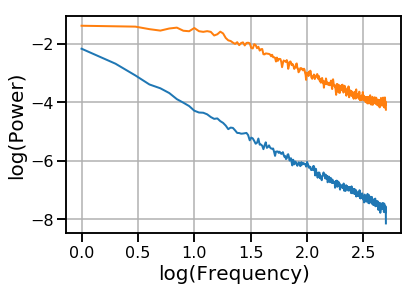

In [23]:
plot_spectra([f1, f2], [p1, p2], True, True)

## DFA Across Exponents

In [19]:
# Run a set of simulations, calculating DFA across exponents
dfa_sims_exp = run_sims(sim_powerlaw, sim_params_pow, dfa_wrapper, dfa_params,
                        update='update_exp', values=exps, n_instances=n_instances)

In [20]:
# Run a set of simulations, calculating DFA across exponents, with an oscillation
dfa_sims_comb_exp = run_sims(sim_combined, sim_params_comb, dfa_wrapper, dfa_params,
                             update='update_comb_exp', values=exps, n_instances=n_instances)

In [21]:
# Calculate the expected DFA exponent value for each powerlaw exponent
expected = [expected_alpha(exp) for exp in exps]

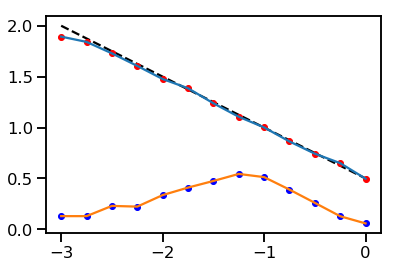

In [22]:
# Plot DFA measures
plt.plot(exps, expected, '--k')

plt.plot(exps, dfa_sims_exp, '.r', ms=12)
plt.plot(exps, dfa_sims_exp)

plt.plot(exps, dfa_sims_comb_exp, '.b', ms=12)
plt.plot(exps, dfa_sims_comb_exp);

In [24]:
# Run a set of simulations, calculating DFA across oscillation frequencies
dfa_sims_freq = run_sims(sim_combined, sim_params_comb, dfa_wrapper, dfa_params,
                        update='update_freq', values=freqs, n_instances=n_instances)

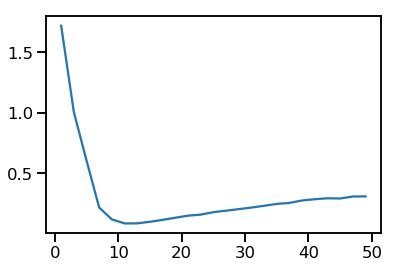

In [25]:
# Plot DFA measures across oscillation frequency values
plt.plot(freqs, dfa_sims_freq)

In [26]:
# Run a set of simulations, calculating DFA across oscillation power
dfa_sims_pow = run_sims(sim_combined, sim_params_comb, dfa_wrapper, dfa_params,
                        update='update_pow', values=pows, n_instances=n_instances)

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


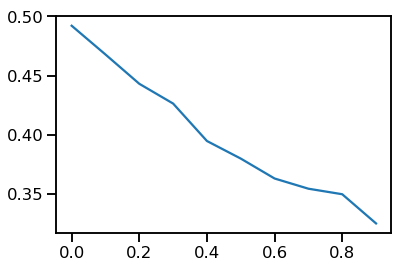

In [27]:
# Plot DFA measures across oscillation power values
plt.plot(pows, dfa_sims_pow)

# DFA

In [4]:
# Copied from rdgao SpaceRecon / nlds

import numpy as np
import scipy as sp

def dfa(data, fs, n_scales=10, min_scale=0.01, max_scale=1.0, deg=1, method='dfa'):
    """ Perform Detrended Fluctuation Analysis (DFA) on a given time series by
    dividing the data into non-overlapping windows at log-spaced scales and
    computing the mean RMS of fits over all window at each scale.
    
    Parameters
    ----------
    data : array, 1-D
        Data to compute DFA over.
    fs : float, Hz
        Sampling frequency of data.
    n_scales : int (default=10)
        Number of scales to estimate fluctuations over.
    min_scale : float, seconds (default=0.01s)
        Shortest scale to compute DFA over.
    max_scale : float, seconds (default=1.0s)
        Longest scale to compute DFA over.
    deg : int (default=1)
        Polynomial degree for detrending. 1 for regular DFA, 2 or higher for
        generalized DFA.
    method : str (default='dfa')
        Method to compute per-window fluctuation.
        'dfa' : detrended fluctuation (OLS fit of data window). Empirically, DFA
            seems to work for a larger range of exponent values.
        'rs' : rescaled range (range divided by std)
        
    Returns
    -------
    t_scales : array, 1-D
        Time-scales over which detrended fluctuations was performedself.
    DFs : array, 1-D
        Mean RMS (fluctuations) at each scale.
    alpha : float
        Slope of line in loglog when plotting t_scales against DFs (Hurst exp.).
    """
    
    # get log10 equi-spaced scales and translate that into window lengths
    t_scales = np.logspace(np.log10(min_scale), np.log10(max_scale), n_scales)
    win_lens = np.round(t_scales * fs).astype('int')
    # get culmulative sum
    data_walk = sp.cumsum(data - np.mean(data))
    DFs = np.zeros_like(t_scales)
    # step through each scale and get RMS
    for idx, win_len in enumerate(win_lens):
        if method is 'dfa':
            DFs[idx] = compute_DF(data_walk, win_len=win_len, deg=deg)
        elif method is 'rs':
            DFs[idx] = compute_RS(data_walk, win_len=win_len)

    # get DFA exponent
    alpha = np.polyfit(np.log10(t_scales), np.log10(DFs), deg=1)[0]
    return t_scales, DFs, alpha


def compute_RS(data, win_len):
    """Compute rescaled range of a given time-series at a given scale.
    
    Parameters
    ----------
    data : array, 1-D
        Data to compute R/S over.
    win_len : int
        Window length for each R/S computation.
        
    Returns
    -------
    x : float
        Mean R/S over all sub-windows of data.
    """
    
    # gather all windows
    n_win = int(np.floor(len(data) / win_len))
    # vectorize the data so we can call math functions in one go
    Z_rect = np.reshape(data[:n_win * win_len], (n_win, win_len)).T
    # get back the data by taking the derivative of data_walk
    X = np.concatenate((data[:1],np.diff(data)))
    X_rect = np.reshape(X[:n_win * win_len], (n_win, win_len)).T

    RS_seg = np.ptp(Z_rect, axis=0)/np.std(X_rect, axis=0)
    return np.mean(RS_seg)


def compute_DF(data, win_len, deg=1):
    """ Compute detrended fluctuation of the data at the given window length.
    
    Parameters
    ----------
    data : array, 1-D
        Data to compute DFA over.
    win_len : int
        Window length for each DF fit.
    deg : int (default=1)
        Polynomial degree for detrending.
        
    Returns
    -------
    x : float
        mean RMS across fits.
    """
    
    # gather all windows
    n_win = int(np.floor(len(data) / win_len))
    # vectorize the data so we can call np.polyfit in one go
    data_rect = np.reshape(data[:n_win * win_len], (n_win, win_len)).T
    # fitting
    coef, fluc, _, _, _ = np.polyfit(
        np.arange(win_len), data_rect, deg=deg, full=True)
    # fluc cntains sum of squared error, we want mean RMS across fits
    return np.mean((fluc / win_len)**0.5)